In [1]:
import numpy as np
import os
from scipy.stats import norm
import scipy.optimize as opt
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from pandas.tseries.offsets import DateOffset
from dateutil.relativedelta import relativedelta
from scipy.optimize import fsolve
import datetime
import copy
from sklearn.metrics import mean_squared_error

## Fixed income functions

In [4]:
# curve data
os.chdir('INSERT_DATA_PATH_HERE')
EUSA = pd.read_excel('EUSA_data.xlsx')

# change dataframe layout
index = EUSA['Dates'].copy()
EUSA = pd.melt(EUSA.reset_index(),
               id_vars=['Dates'],
               value_vars=['6M', '1Y', '2Y', '3Y', '4Y', '5Y', '6Y', '7Y', '8Y', '9Y', '10Y', '12Y', '15Y', '20Y', '25Y', '30Y'],
               var_name='Maturity', value_name='Spot rate').set_index(['Dates'])
EUSA.name = 'EUSA'

# convert strings to float
def maturity_convert(Maturity):
    if Maturity[-1] == 'M':
        MaturityInYear = float(Maturity[:-1]) / 12  # if 6M -> 6/12
    else:
        MaturityInYear = float(Maturity[:-1])       # if xY -> float(x)
    return MaturityInYear

EUSA['Maturity (years)'] = EUSA['Maturity'].apply(lambda x: maturity_convert(x))

# change % to decimal
EUSA['Spot rate (decimal)'] = EUSA['Spot rate'].apply(lambda x: x / 100)

# cubic spline interpolation
def cubspline_curve(date, T, df_curve):
    S = interp1d(df_curve['Maturity (years)'][str(date)], 
                 df_curve['Spot rate (decimal)'][str(date)], 
                 kind='cubic', 
                 fill_value='extrapolate')
    return S(T)

def disc_factor(date, T, curve = EUSA):
    
    rate = np.log(1 + cubspline_curve(date, T, curve))

    return np.exp(-rate * T)

def forw_rate(date, T, tau, curve = EUSA):

    P_0_T = disc_factor(date, T, curve)
    P_0_T_tau = disc_factor(date, T+tau, curve)

    return 1 / tau * (P_0_T / P_0_T_tau - 1)

def payment_schedule(date, expiry, tenor, tau):
    unadj_dates = []
    adj_dates = []

    t_0 = pd.Timestamp(date).date()
    t_m = (t_0 + DateOffset(months=(expiry * 12)) + pd.tseries.offsets.BusinessDay(0)).date()
    t_n = (t_m + DateOffset(months=(tenor * 12))).date()
    t_m_copy = t_m

    delta_months = relativedelta(months=+(tau * 12))

    while t_m_copy < t_n:
        unadj_dates.append(t_m_copy)
        t_m_copy = t_m_copy + delta_months

    unadj_dates.append(t_m_copy)

    for date in unadj_dates:
        adj_dates.append((date + pd.tseries.offsets.BusinessDay(0)).date())
    
    return adj_dates

def coverage(date, expiry, tenor, tau):
    coverage = []
    dates = []

    adj_dates = payment_schedule(date, expiry, tenor, tau)
    t_0 = pd.Timestamp(date).date()
    dates_roll = expiry + tau

    for i in range(1, len(adj_dates)):
        coverage.append(1 / 360 * (
            360 * (adj_dates[i].year - adj_dates[i - 1].year)
            + 30 * (adj_dates[i].month - adj_dates[i - 1].month)
            + min(30, adj_dates[i].day) 
            - min(30, adj_dates[i - 1].day)
            )
        )
        dates.append(dates_roll)
        dates_roll = dates_roll + coverage[i - 1]

    return coverage, dates

def swap_rate(date, expiry, tenor, tau_floating, tau_fixed, curve = EUSA):
    floating_leg = 0
    fixed_leg = 0

    floating_coverage, floating_dates = coverage(date, expiry, tenor, tau_floating)
    fixed_coverage, fixed_dates = coverage(date, expiry, tenor, tau_fixed)

    for i in range(len(floating_dates)):
        floating_leg = floating_leg + disc_factor(date, floating_dates[i], curve) * floating_coverage[i] * forw_rate(date, floating_dates[i] - floating_coverage[i], floating_coverage[i],  curve)

    for i in range(len(fixed_dates)):
        fixed_leg = fixed_leg + disc_factor(date, fixed_dates[i]) * fixed_coverage[i]

    return floating_leg / fixed_leg

def annuity_func(date, expiry, tenor, tau, curve = EUSA):
    ann = 0
    cov, dates = coverage(date, expiry, tenor, tau)
    for i in range(len(dates)):
        ann = ann + disc_factor(date, dates[i], curve) * cov[i]
    return ann

def bachelier(F, K, sigma_normal, date, expiry, tenor, tau, t = 0):
    d = (F - K) / (sigma_normal * np.sqrt(expiry - t))
    return annuity_func(date, expiry, tenor, tau) * ((F - K) * norm.cdf(d) + sigma_normal * np.sqrt(expiry - t) * norm.pdf(d))

## Payer swaption functions

In [5]:
def trap_integration(xmin, xmax, N):
    # Computes integration points and weights for trapezoid scheme
    # integrates from xmin to xmax with N integration points
    uv = np.linspace(xmin, xmax, N)
    wgtv = np.ones(N)
    wgtv[[0, N - 1]] = 1 / 2
    wgtv = wgtv * (xmax - xmin) / (N - 1)
    return uv, wgtv

def char_func(u, T, theta, eta, z_0, lambd, b):
    v = 1/2 * (lambd * b)**2 * u * (u - 1)

    gamma = np.sqrt(theta**2 - 2 * eta**2 * v)
    A = 1 / eta**2 * theta * z_0 * (2 * np.log(2 * gamma / (theta + gamma - np.exp(-gamma * T)*(theta - gamma))) + (theta - gamma) * T)
    B = 2 * v * (1 - np.exp(-gamma * T)) / ((theta + gamma) * (1 - np.exp(-gamma * T)) + 2 * gamma * np.exp(-gamma * T))
    return np.exp(A + B * z_0)

def payer_price_SV(S, K, L, theta, eta, lambd, b, z_0, date, expiry, tenor):
    xmin = 0
    xmax = 2000
    int_points = 10000
    [u, wgt] = trap_integration(xmin, xmax, int_points)
    
    S_prime = b * S + (1 - b) * L + 0.025   # interim fix to the fact that ln(K_prime/S_prime) is undefined if one of either is negative
    K_prime = b * K + (1 - b) * L + 0.025

    integrand = np.real((np.exp(-(1/2 + 1j * u) * np.log(K_prime / S_prime)) * char_func(1/2 + 1j * u, expiry, theta, eta, z_0, lambd, b)) / (u**2 + 1/4))
    integral = sum(wgt * integrand)

    annuity = annuity_func(date, expiry, tenor, tau_floating_leg, EUSA)

    return annuity / b * (S_prime - K_prime / np.pi * integral)

## Misc inputs

In [6]:
date = datetime.date(2019,9,19)
tau_floating = 0.5      # EUSA swaps are semi-annual
tau_floating_leg = 0.5
tau_fixed = 1           # fixed rates paid annually
z_0 = 1

## Load data

In [7]:
swaption_data = pd.read_excel('swaption_cube_19.xlsx')
number_of_grids = len(pd.ExcelFile('swaption_cube_19.xlsx').sheet_names) / 2
xl_names = pd.ExcelFile('swaption_cube_19.xlsx').sheet_names[:int(number_of_grids)]

df_swaption_iv = []
df_swaption_strikes = []

for i in range(int(number_of_grids)):
    grid_i = pd.read_excel('swaption_cube_19.xlsx', sheet_name=(i), index_col = 0)
    grid_i.name = grid_i.index.name
    df_swaption_iv.append(grid_i)
    
for i in range(int(number_of_grids),2*int(number_of_grids)):
    grid_i = pd.read_excel('swaption_cube_19.xlsx', sheet_name=(i), index_col = 0)
    grid_i.name = grid_i.index.name
    df_swaption_strikes.append(grid_i)

# the swaption_iv holds the swaption grid for different strikes
# its dimensions are (m, n, #number of strikes)
# the calibration will be done for each (m, n)-pair with weights assigned for each strike
# access the grids by swaption_iv[i]
# access grid-points by swaption_iv[i].iloc[j,k]

## Set up lists with strikes, swap rates, and prices

In [8]:
swaption_expiry = np.array([1/12, 3/12, 6/12, 9/12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30])
swaption_tenor = np.array([2, 5, 10])

df_strike = []
df_swap_rate = []
df_price = []

for i in range(len(df_swaption_iv)): # grid loop
    [M,N] = df_swaption_iv[i].shape

    df_strike_i = df_swaption_iv[i].copy()
    df_swap_rate_i = df_swaption_iv[i].copy()
    df_price_i = df_swaption_iv[i].copy()

    for m in range(M): # expiry loop
        T = swaption_expiry[m]      

        for n in range(N): # tenor loop
            tenor = swaption_tenor[n]
            moneyness = float(df_swaption_strikes[i].name) / 10000  # convert from bps. to decimal

            K = df_swaption_strikes[i].iloc[m,n] / 100
            S = K - moneyness

            normal_vol = df_swaption_iv[i].iloc[m,n] / 10000   # convert from bps. to decimal
            
            df_strike_i.iloc[m,n] = K
            df_swap_rate_i.iloc[m,n] = S
            df_price_i.iloc[m,n] = bachelier(S, K, normal_vol, date, T, tenor, tau_floating, t = 0)  # bachelier price (since data uses normal vols)
    
    df_strike.append(pd.DataFrame(df_strike_i))
    df_swap_rate.append(pd.DataFrame(df_swap_rate_i))
    df_price.append(pd.DataFrame(df_price_i))

## 10-year swap rate strips

In [9]:
strike_strips = []
swaprate_strips = []
price_strips = []

for i in range(len(df_strike)):
    strike_strips.append(df_strike[i].loc[:,"10Yr"])
    swaprate_strips.append(df_swap_rate[i].loc[:,"10Yr"])
    price_strips.append(df_price[i].loc[:,"10Yr"])

tenor = 10

### 10-year tenor swaptions, market implied volatility

In [10]:
expiries = ["2Yr", "5Yr", "8Yr", "10Yr", "15Yr","20Yr"]
strike_index = np.array([200, 100, 50, 25, 0, -25, -50, -100, -200])

iv_smiles = []

for i in range(len(expiries)):

    expiry = expiries[i]

    smile_i = pd.Series([df_swaption_iv[0].loc[expiry, "10Yr"], df_swaption_iv[1].loc[expiry,"10Yr"], df_swaption_iv[2].loc[expiry,"10Yr"], df_swaption_iv[3].loc[expiry,"10Yr"], 
                         df_swaption_iv[4].loc[expiry,"10Yr"], # ATM
                         df_swaption_iv[5].loc[expiry,"10Yr"], df_swaption_iv[6].loc[expiry,"10Yr"], df_swaption_iv[7].loc[expiry,"10Yr"], df_swaption_iv[8].loc[expiry,"10Yr"]],
                         index = strike_index)
    iv_smiles.append(smile_i)

## Calibration 1: fixed parameters

In [ ]:
expiry = np.array([1/12, 3/12, 6/12, 9/12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30])

def pricing_fixed(lambd, b, eta, theta):

    M = len(expiry)
    prices = copy.deepcopy(price_strips)
    
    print("lambda =", lambd, "b =", b, "eta =", eta, "theta =", theta)
    for m in range(M):  # option expiry
        T = expiry[m]

        for i in range(len(strike_strips)): # strike level
            
            K = strike_strips[i][m]
            S = swaprate_strips[i][m]

            model_price = payer_price_SV(S, K, S, theta, eta, lambd, b, z_0, date, T, tenor)
            prices[i][m] = model_price

    return prices

# moneyness            +200  +100  +50  +25   ATM  -25   -50  -100  -200
weightings = np.array([0.05, 0.05, 0.1, 0.15, 0.3, 0.15, 0.1, 0.05, 0.05])

weights = copy.deepcopy(price_strips)
for n in range(len(weightings)):
    weights[n].iloc[:] = weightings[n]

bounds = ((1e-8, np.inf),(1e-8, np.inf),(1e-8, np.inf),(1e-8, np.inf))

init_lambd = 0.3
init_b = 0.2
init_eta = 1.0
init_theta = 0.3
initguess = [init_lambd, init_b, init_eta, init_theta]

def Err(x):
    lambd, b, eta, theta = x
    err = np.sum(weights * (np.array(pricing_fixed(lambd, b, eta, theta)) - np.array(price_strips))**2)
    print("objective function =", err)
    return err

res = opt.minimize(Err, initguess, bounds = bounds, tol = 1e-12)
lambd, b, eta, theta = res.x

In [11]:
# result:
lambd =	0.18996756980039659
b =	0.1789580546389074
eta = 0.9577069321554951
theta = 0.23768696366731049

### Model implied volatilities

In [12]:
expiries = pd.Series(data = np.array([1/12, 3/12, 6/12, 9/12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30]), 
                     index = ["1Mo","3Mo","6Mo","9Mo","1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"])

points = ["2Yr", "5Yr", "8Yr", "10Yr", "15Yr","20Yr"]

IV_1 = []

for i in range(len(points)):

    S = swaprate_strips[4][points[i]]

    strikes = np.linspace(S -200/10000, S + 200/10000, 49)
    IV_index = np.round(np.linspace(-200, 200, len(strikes)),2)

    IV_i = pd.Series(np.zeros(len(strikes)),
                     index = IV_index)

    T = expiries[points[i]]

    for n in range(len(strikes)):

        K = strikes[n]
    
        def Root_Solving(x):
            return bachelier(S, K, x, date, T, tenor, tau_floating, t = 0) - payer_price_SV(S, K, S, theta, eta, lambd, b, z_0, date, T, tenor)

        res = fsolve(Root_Solving, 0.01)

        IV_i.iloc[n] = res * 10000   # convert to bp

    IV_1.append(IV_i)

### Implied volatility plots: model vs. market

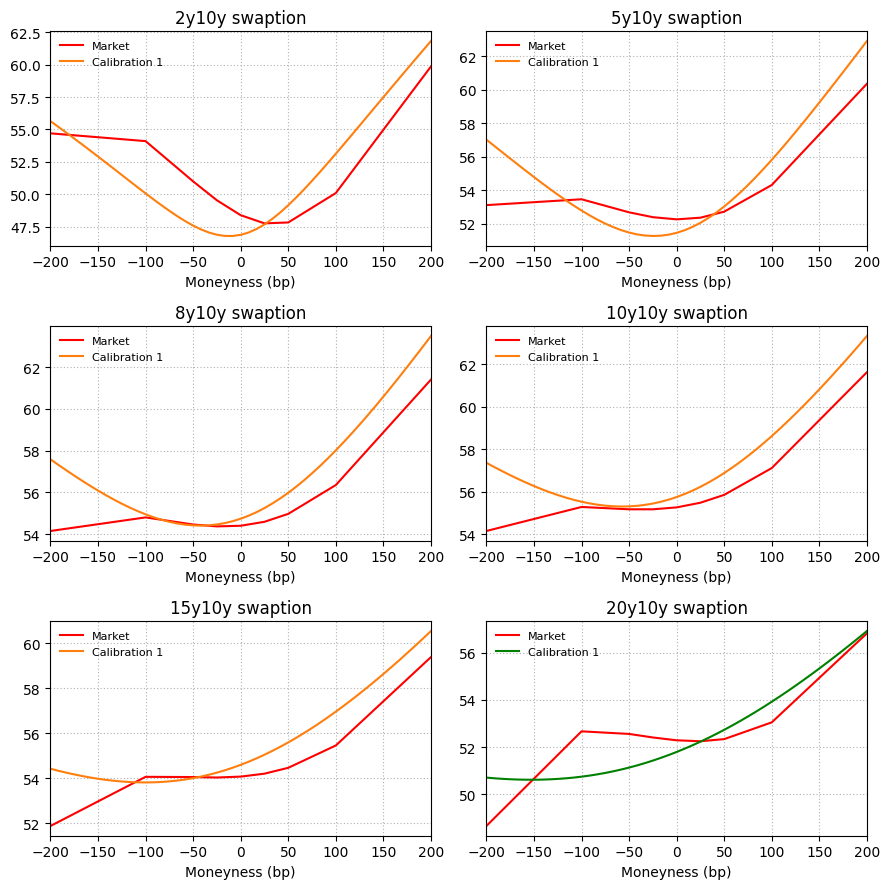

In [13]:
fig, ax = plt.subplots(3, 2, figsize=(9,9))

ax[0, 0].plot(iv_smiles[0].index, iv_smiles[0], label = 'Market', color = 'r')
ax[0, 0].plot(IV_1[0].index, IV_1[0], label = 'Calibration 1', color = '#ff7f0e')
ax[0, 0].set_title('2y10y swaption')
ax[0, 0].set_xlim(min(IV_index), max(IV_index))
ax[0, 0].set_xlabel('Moneyness (bp)')
ax[0, 0].grid(ls = (0,(1,2)))
ax[0, 0].legend(frameon=False, fontsize=8)

ax[0, 1].plot(iv_smiles[1].index, iv_smiles[1], label = 'Market', color = 'r')
ax[0, 1].plot(IV_1[1].index, IV_1[1], label = 'Calibration 1', color = '#ff7f0e')
ax[0, 1].set_title('5y10y swaption')
ax[0, 1].set_xlim(min(IV_index), max(IV_index))
ax[0, 1].set_xlabel('Moneyness (bp)')
ax[0, 1].grid(ls = (0,(1,2)))
ax[0, 1].legend(frameon=False, fontsize=8)

ax[1, 0].plot(iv_smiles[2].index, iv_smiles[2], label = 'Market', color = 'r')
ax[1, 0].plot(IV_1[2].index, IV_1[2], label = 'Calibration 1', color = '#ff7f0e')
ax[1, 0].set_title('8y10y swaption')
ax[1, 0].set_xlim(min(IV_index), max(IV_index))
ax[1, 0].set_xlabel('Moneyness (bp)')
ax[1, 0].grid(ls = (0,(1,2)))
ax[1, 0].legend(frameon=False, fontsize=8)

ax[1, 1].plot(iv_smiles[3].index, iv_smiles[3], label = 'Market', color = 'r')
ax[1, 1].plot(IV_1[3].index, IV_1[3], label = 'Calibration 1', color = '#ff7f0e')
ax[1, 1].set_title('10y10y swaption')
ax[1, 1].set_xlim(min(IV_index), max(IV_index))
ax[1, 1].set_xlabel('Moneyness (bp)')
ax[1, 1].grid(ls = (0,(1,2)))
ax[1, 1].legend(frameon=False, fontsize=8)

ax[2, 0].plot(iv_smiles[4].index, iv_smiles[4], label = 'Market', color = 'r')
ax[2, 0].plot(IV_1[4].index, IV_1[4], label = 'Calibration 1', color = '#ff7f0e')
ax[2, 0].set_title('15y10y swaption')
ax[2, 0].set_xlim(min(IV_index), max(IV_index))
ax[2, 0].set_xlabel('Moneyness (bp)')
ax[2, 0].grid(ls = (0,(1,2)))
ax[2, 0].legend(frameon=False, fontsize=8)

ax[2, 1].plot(iv_smiles[5].index, iv_smiles[5], label = 'Market', color = 'r')
ax[2, 1].plot(IV_1[5].index, IV_1[5], label = 'Calibration 1', color = 'g')
ax[2, 1].set_title('20y10y swaption')
ax[2, 1].set_xlim(min(IV_index), max(IV_index))
ax[2, 1].set_xlabel('Moneyness (bp)')
ax[2, 1].grid(ls = (0,(1,2)))
ax[2, 1].legend(frameon=False, fontsize=8)

fig.tight_layout()
plt.show()

## Errors across all option expiries
##### Model

In [14]:
expiries = pd.Series(data = np.array([1/12, 3/12, 6/12, 9/12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30]), 
                     index = ["1Mo","3Mo","6Mo","9Mo","1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"])

points = ["1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"]  # errors for very short option expiries

IV_1_errors = []

for i in range(len(points)):

    S = swaprate_strips[4][points[i]]

    strikes = np.array([S-200/10000, S-100/10000, S-50/10000, S-25/10000,
                    S-0/10000,
                    S+25/10000, S+50/10000, S+100/10000, S+200/10000])

    IV_index = np.round(np.linspace(-200, 200, len(strikes)),2)

    IV_i = pd.Series(np.zeros(len(strikes)),
                     index = IV_index)
  
    T = expiries[points[i]]

    for n in range(len(strikes)):

        K = strikes[n]
            
        def Root_Solving(x):
            return bachelier(S, K, x, date, T, tenor, tau_floating, t = 0) - payer_price_SV(S, K, S, theta, eta, lambd, b, z_0, date, T, tenor)

        res = fsolve(Root_Solving, 0.01)

        IV_i.iloc[n] = res * 10000   # convert to bp

    IV_1_errors.append(IV_i)

##### Market

In [15]:
expiries = ["1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"]
strike_index = np.array([-200, -100, -50, -25, 0, 25, 50, 100, 200])

iv_smiles = []

for i in range(len(expiries)):
    expiry = expiries[i]
    smile_i = pd.Series([df_swaption_iv[8].loc[expiry,"10Yr"], df_swaption_iv[7].loc[expiry,"10Yr"], df_swaption_iv[6].loc[expiry,"10Yr"], df_swaption_iv[5].loc[expiry,"10Yr"],                   
                         df_swaption_iv[4].loc[expiry,"10Yr"], # ATM
                         df_swaption_iv[3].loc[expiry,"10Yr"], df_swaption_iv[2].loc[expiry,"10Yr"], df_swaption_iv[1].loc[expiry,"10Yr"], df_swaption_iv[0].loc[expiry, "10Yr"]],
                         index = strike_index)
    iv_smiles.append(smile_i)

In [16]:
rmse = []

for i in range(len(points)):

    rmse_i = np.sqrt(mean_squared_error(iv_smiles[i], IV_1_errors[i]))
    rmse.append(rmse_i)

avg_rmse = np.average(rmse)
display(pd.DataFrame(data= rmse, index = expiries, columns = ['RMSE, Calibration 1']))
print("Average root mean squared error =", avg_rmse)

,"RMSE, Calibration 1"
1Yr,7.464558
2Yr,2.427447
3Yr,1.962859
4Yr,1.733610
5Yr,1.765547
6Yr,1.637302
7Yr,1.603536
8Yr,1.508773
9Yr,1.418329
10Yr,1.392905


Average root mean squared error = 2.098347568499423


## Calibration with constant parameters and $\lambda(t)$

In [ ]:
expiry = np.array([1/12, 3/12, 6/12, 9/12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30])

def pricing_lambd(b, eta, theta, lambda_1, lambda_2, lambda_3, lambda_4, lambda_5, lambda_6, lambda_7, lambda_8, lambda_9, lambda_10, lambda_11, lambda_12, lambda_13, lambda_14, lambda_15, lambda_16, lambda_17, lambda_18, lambda_19):

    lambdas = np.array([lambda_1, lambda_2, lambda_3, lambda_4, lambda_5, lambda_6, lambda_7, lambda_8, lambda_9, lambda_10, lambda_11, lambda_12, lambda_13, lambda_14, lambda_15, lambda_16, lambda_17, lambda_18, lambda_19])

    M = len(expiry)
    prices = copy.deepcopy(price_strips)
    
    for m in range(M):  # option expiry
        T = expiry[m]
        lambd = lambdas[m]
        print("b =", b, "eta = ", eta, "theta =", theta, "lambda =", lambd)
        for i in range(len(strike_strips)): # strike level
            
            K = strike_strips[i][m]
            S = swaprate_strips[i][m]

            model_price = payer_price_SV(S, K, S, theta, eta, lambd, b, z_0, date, T, tenor)
            prices[i][m] = model_price

    return prices

# moneyness            +200  +100  +50  +25   ATM  -25   -50  -100  -200
weightings = np.array([0.05, 0.05, 0.1, 0.15, 0.3, 0.15, 0.1, 0.05, 0.05])

weights = copy.deepcopy(price_strips)
for n in range(len(weightings)):
    weights[n].iloc[:] = weightings[n]

bounds = ((1e-8, np.inf),(1e-8, np.inf),(1e-8, np.inf),
          (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), 
          (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf))

init_b = 0.15
init_eta = 1.5
init_theta = 0.40
init_lambda_1 = 0.3
init_lambda_2 = 0.3
init_lambda_3 = 0.3
init_lambda_4 = 0.3
init_lambda_5 = 0.3
init_lambda_6 = 0.3
init_lambda_7 = 0.3
init_lambda_8 = 0.3
init_lambda_9 = 0.3
init_lambda_10 = 0.3
init_lambda_11 = 0.3
init_lambda_12 = 0.3
init_lambda_13 = 0.3
init_lambda_14 = 0.3
init_lambda_15 = 0.3
init_lambda_16 = 0.3
init_lambda_17 = 0.3
init_lambda_18 = 0.3
init_lambda_19 = 0.3
initguess = [init_b, init_eta, init_theta,
             init_lambda_1, init_lambda_2, init_lambda_3, init_lambda_4, init_lambda_5, init_lambda_6, init_lambda_7, init_lambda_8, init_lambda_9, init_lambda_10, init_lambda_11, init_lambda_12, init_lambda_13, init_lambda_14, init_lambda_15, init_lambda_16, init_lambda_17, init_lambda_18, init_lambda_19]

def Err(x):
    b, eta, theta, lambda_1, lambda_2, lambda_3, lambda_4, lambda_5, lambda_6, lambda_7, lambda_8, lambda_9, lambda_10, lambda_11, lambda_12, lambda_13, lambda_14, lambda_15, lambda_16, lambda_17, lambda_18, lambda_19 = x
    err = np.sum(weights * (np.array(pricing_lambd(b, eta, theta, lambda_1, lambda_2, lambda_3, lambda_4, lambda_5, lambda_6, lambda_7, lambda_8, lambda_9, lambda_10, lambda_11, lambda_12, lambda_13, lambda_14, lambda_15, lambda_16, lambda_17, lambda_18, lambda_19))
                            -np.array(price_strips))**2)
    print("Objective function =", err)
    return err

res = opt.minimize(Err, initguess, bounds = bounds, tol = 1e-12)
b, eta, theta, lambda_1, lambda_2, lambda_3, lambda_4, lambda_5, lambda_6, lambda_7, lambda_8, lambda_9, lambda_10, lambda_11, lambda_12, lambda_13, lambda_14, lambda_15, lambda_16, lambda_17, lambda_18, lambda_19 = res.x
lambdas = pd.Series(data = np.array([lambda_1, lambda_2, lambda_3, lambda_4, lambda_5, lambda_6, lambda_7, lambda_8, lambda_9, lambda_10, lambda_11, lambda_12, lambda_13, lambda_14, lambda_15, lambda_16, lambda_17, lambda_18, lambda_19]), 
                    index = ["1Mo","3Mo","6Mo","9Mo","1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"])

In [17]:
# result:
b =	0.180024407957273
eta = 1.3889626672482
theta = 0.714397341741249
lambdas = pd.Series(data = np.array([0.23142747, 0.22392409, 0.20841536, 0.20501973, 0.20180459, 0.19610248, 0.19278537, 0.19046998, 0.18773363, 0.1848987, 0.1818808, 0.18194688, 0.18148715, 0.18106108, 0.18025282, 0.1809604, 0.18489099, 0.18551875, 0.18541091]), 
                    index = ["1Mo","3Mo","6Mo","9Mo","1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"])

### Model implied volatilities

In [18]:
expiries = pd.Series(data = np.array([1/12, 3/12, 6/12, 9/12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30]), 
                     index = ["1Mo","3Mo","6Mo","9Mo","1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"])

points = ["2Yr", "5Yr", "8Yr", "10Yr", "15Yr","20Yr"]

IV_2 = []

for i in range(len(points)):
    lambd = lambdas[points[i]]

    S = swaprate_strips[4][points[i]]

    strikes = np.linspace(S -200/10000, S + 200/10000, 49)
    IV_index = np.round(np.linspace(-200, 200, len(strikes)),2)

    IV_i = pd.Series(np.zeros(len(strikes)),
                     index = IV_index)
  
    T = expiries[points[i]]

    for n in range(len(strikes)):

        K = strikes[n]    
        def Root_Solving(x):
            return bachelier(S, K, x, date, T, tenor, tau_floating, t = 0) - payer_price_SV(S, K, S, theta, eta, lambd, b, z_0, date, T, tenor)
        res = fsolve(Root_Solving, 0.01)

        IV_i.iloc[n] = res * 10000   # convert to bp

    IV_2.append(IV_i)

In [19]:
expiries = ["2Yr", "5Yr", "8Yr", "10Yr", "15Yr","20Yr"]
strike_index = np.array([200, 100, 50, 25, 0, -25, -50, -100, -200])

iv_smiles = []

for i in range(len(expiries)):

    expiry = expiries[i]

    smile_i = pd.Series([df_swaption_iv[0].loc[expiry, "10Yr"], df_swaption_iv[1].loc[expiry,"10Yr"], df_swaption_iv[2].loc[expiry,"10Yr"], df_swaption_iv[3].loc[expiry,"10Yr"], 
                         df_swaption_iv[4].loc[expiry,"10Yr"], # ATM
                         df_swaption_iv[5].loc[expiry,"10Yr"], df_swaption_iv[6].loc[expiry,"10Yr"], df_swaption_iv[7].loc[expiry,"10Yr"], df_swaption_iv[8].loc[expiry,"10Yr"]],
                         index = strike_index)
    iv_smiles.append(smile_i)

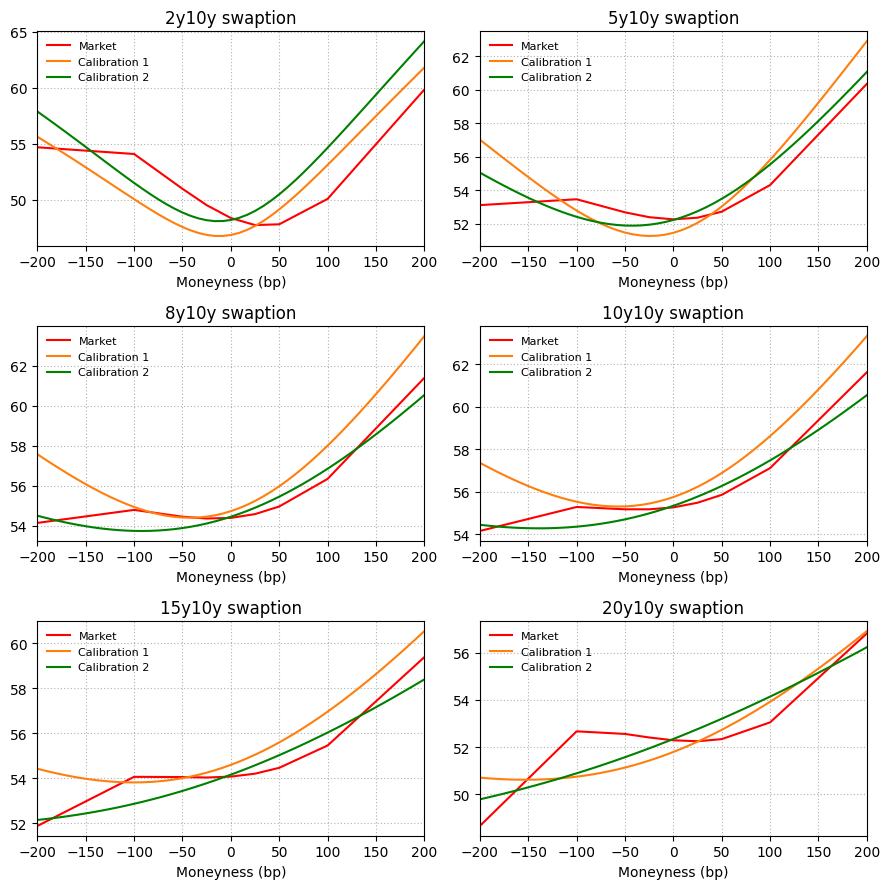

In [20]:
fig, ax = plt.subplots(3, 2, figsize=(9,9))

ax[0, 0].plot(iv_smiles[0].index, iv_smiles[0], label = 'Market', color = 'r')
ax[0, 0].plot(IV_1[0].index, IV_1[0], label = 'Calibration 1', color = '#ff7f0e')
ax[0, 0].plot(IV_2[0].index, IV_2[0], label = 'Calibration 2', color = 'g')
ax[0, 0].set_title('2y10y swaption')
ax[0, 0].set_xlim(min(IV_index), max(IV_index))
ax[0, 0].set_xlabel('Moneyness (bp)')
ax[0, 0].grid(ls = (0,(1,2)))
ax[0, 0].legend(frameon=False, fontsize=8)

ax[0, 1].plot(iv_smiles[1].index, iv_smiles[1], label = 'Market', color = 'r')
ax[0, 1].plot(IV_1[1].index, IV_1[1], label = 'Calibration 1', color = '#ff7f0e')
ax[0, 1].plot(IV_2[1].index, IV_2[1], label = 'Calibration 2', color = 'g')
ax[0, 1].set_title('5y10y swaption')
ax[0, 1].set_xlim(min(IV_index), max(IV_index))
ax[0, 1].set_xlabel('Moneyness (bp)')
ax[0, 1].grid(ls = (0,(1,2)))
ax[0, 1].legend(frameon=False, fontsize=8)

ax[1, 0].plot(iv_smiles[2].index, iv_smiles[2], label = 'Market', color = 'r')
ax[1, 0].plot(IV_1[2].index, IV_1[2], label = 'Calibration 1', color = '#ff7f0e')
ax[1, 0].plot(IV_2[2].index, IV_2[2], label = 'Calibration 2', color = 'g')
ax[1, 0].set_title('8y10y swaption')
ax[1, 0].set_xlim(min(IV_index), max(IV_index))
ax[1, 0].set_xlabel('Moneyness (bp)')
ax[1, 0].grid(ls = (0,(1,2)))
ax[1, 0].legend(frameon=False, fontsize=8)

ax[1, 1].plot(iv_smiles[3].index, iv_smiles[3], label = 'Market', color = 'r')
ax[1, 1].plot(IV_1[3].index, IV_1[3], label = 'Calibration 1', color = '#ff7f0e')
ax[1, 1].plot(IV_2[3].index, IV_2[3], label = 'Calibration 2', color = 'g')
ax[1, 1].set_title('10y10y swaption')
ax[1, 1].set_xlim(min(IV_index), max(IV_index))
ax[1, 1].set_xlabel('Moneyness (bp)')
ax[1, 1].grid(ls = (0,(1,2)))
ax[1, 1].legend(frameon=False, fontsize=8)

ax[2, 0].plot(iv_smiles[4].index, iv_smiles[4], label = 'Market', color = 'r')
ax[2, 0].plot(IV_1[4].index, IV_1[4], label = 'Calibration 1', color = '#ff7f0e')
ax[2, 0].plot(IV_2[4].index, IV_2[4], label = 'Calibration 2', color = 'g')
ax[2, 0].set_title('15y10y swaption')
ax[2, 0].set_xlim(min(IV_index), max(IV_index))
ax[2, 0].set_xlabel('Moneyness (bp)')
ax[2, 0].grid(ls = (0,(1,2)))
ax[2, 0].legend(frameon=False, fontsize=8)

ax[2, 1].plot(iv_smiles[5].index, iv_smiles[5], label = 'Market', color = 'r')
ax[2, 1].plot(IV_1[5].index, IV_1[5], label = 'Calibration 1', color = '#ff7f0e')
ax[2, 1].plot(IV_2[5].index, IV_2[5], label = 'Calibration 2', color = 'g')
ax[2, 1].set_title('20y10y swaption')
ax[2, 1].set_xlim(min(IV_index), max(IV_index))
ax[2, 1].set_xlabel('Moneyness (bp)')
ax[2, 1].grid(ls = (0,(1,2)))
ax[2, 1].legend(frameon=False, fontsize=8)

fig.tight_layout()
plt.show()

## Errors across all option expiries
##### Model

In [21]:
expiries = pd.Series(data = np.array([1/12, 3/12, 6/12, 9/12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30]), 
                     index = ["1Mo","3Mo","6Mo","9Mo","1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"])

points = ["1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"]

IV_2_errors = []

for i in range(len(points)):

    lambd = lambdas[points[i]]
    S = swaprate_strips[4][points[i]]

    strikes = np.array([S-200/10000, S-100/10000, S-50/10000, S-25/10000,
                        S-0/10000,
                        S+25/10000, S+50/10000, S+100/10000, S+200/10000])

    IV_index = np.round(np.linspace(-200, 200, len(strikes)),2)

    IV_i = pd.Series(np.zeros(len(strikes)),
                     index = IV_index)
  
    T = expiries[points[i]]

    for n in range(len(strikes)):

        K = strikes[n]
        def Root_Solving(x):
            return bachelier(S, K, x, date, T, tenor, tau_floating, t = 0) - payer_price_SV(S, K, S, theta, eta, lambd, b, z_0, date, T, tenor)
        res = fsolve(Root_Solving, 0.01)

        IV_i.iloc[n] = res * 10000   # convert to bp

    IV_2_errors.append(IV_i)

##### Market

In [22]:
expiries = ["1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"]
strike_index = np.array([-200, -100, -50, -25, 0, 25, 50, 100, 200])

iv_smiles = []

for i in range(len(expiries)):
    expiry = expiries[i]
    smile_i = pd.Series([df_swaption_iv[8].loc[expiry,"10Yr"], df_swaption_iv[7].loc[expiry,"10Yr"], df_swaption_iv[6].loc[expiry,"10Yr"], df_swaption_iv[5].loc[expiry,"10Yr"],                   
                         df_swaption_iv[4].loc[expiry,"10Yr"], # ATM
                         df_swaption_iv[3].loc[expiry,"10Yr"], df_swaption_iv[2].loc[expiry,"10Yr"], df_swaption_iv[1].loc[expiry,"10Yr"], df_swaption_iv[0].loc[expiry, "10Yr"]],
                         index = strike_index)
    iv_smiles.append(smile_i)

In [23]:
rmse = []

for i in range(len(points)):

    rmse_i = np.sqrt(mean_squared_error(iv_smiles[i], IV_2_errors[i]))
    rmse.append(rmse_i)

avg_rmse = np.average(rmse)
display(pd.DataFrame(data= rmse, index = expiries, columns = ['RMSE, Calibration 2']))
print("Average root mean squared error =", avg_rmse)

,"RMSE, Calibration 2"
1Yr,4.472567
2Yr,2.820233
3Yr,1.871934
4Yr,1.280168
5Yr,0.968989
6Yr,0.696627
7Yr,0.738852
8Yr,0.572820
9Yr,0.567760
10Yr,0.553821


Average root mean squared error = 1.4143366262166253


## Calibration with $\lambda(t), b(t), \eta(t)$

In [ ]:
expiry = np.array([1/12, 3/12, 6/12, 9/12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30])

# moneyness         +200  +100  +50  +25   ATM  -25   -50  -100  -200
weights = np.array([0.05, 0.05, 0.1, 0.15, 0.3, 0.15, 0.1, 0.05, 0.05])

lambd_calibrated = price_strips[0].copy()
b_calibrated = price_strips[0].copy()
eta_calibrated = price_strips[0].copy()
model_prices = price_strips[0].copy()

theta = 0.714397341741249

M = len(expiry)

for m in range(M):  # calibrate swaption m
    T = expiry[m]
    print("Expiry = ", T)

    strikes_i = []
    swap_rate_i = []
    market_price_i = []

    for i in range(len(strike_strips)): # strikes loop

        strikes_i.append(strike_strips[i].iloc[m])
        swap_rate_i.append(swaprate_strips[i].iloc[m])
        market_price_i.append(price_strips[i].iloc[m])

    for p in range(1):  # calibrate (m,n)-swaption
        strikes = np.array(strikes_i)
        obs_prices = np.array(market_price_i)
        obs_swap_rates = np.array(swap_rate_i)

        bounds = ((1e-8, np.inf),(1e-8, np.inf),(1e-8, np.inf))

        init_lambd = 0.5
        init_b = 0.50
        init_eta = 0.50
        initguess = [init_lambd, init_b, init_eta]

        def Err(x):
            lambd, b, eta = x

            price_hat = []

            for i in range(len(strike_strips)):
                
                price_hat.append(payer_price_SV(obs_swap_rates[i], strikes[i], obs_swap_rates[i], theta, eta, lambd, b, z_0, date, T, tenor))

            price_hat = np.array(price_hat)
            err = np.sum(weights * (price_hat - obs_prices)**2)

            return err

    res = opt.minimize(Err, initguess, bounds = bounds, tol = 1e-14)
    lambd, b, eta = res.x

    lambd_calibrated[m] = lambd
    b_calibrated[m] = b
    eta_calibrated[m] = eta

    print('\n', "observed ATM price = ", market_price_i[4]) # market price
    print('\n', "calibrated ATM price = ", payer_price_SV(obs_swap_rates[4], strikes[4], obs_swap_rates[4], theta, eta, lambd, b, z_0, date, T, tenor))
    print('\n', 'calibrated lambda', lambd)
    print('\n', 'calibrated b', b)
    print('\n', 'calibrated eta', eta)

In [24]:
# result:
lambd_calibrated = pd.Series(data = np.array([0.23432757, 0.22832776, 0.21239419, 0.20989871, 0.20458665, 0.19417452, 0.19162511, 0.18950253, 0.18643243, 0.18467962, 0.18448355, 0.18315475, 0.1830693, 0.18275957, 0.18249228,0.18304122, 0.18442, 0.18276165, 0.18336802]), 
                             index = ["1Mo","3Mo","6Mo","9Mo","1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"])

b_calibrated = pd.Series(data = np.array([0.01899839, 0.01324599, 0.01135441, 0.00799124, 0.00687906, 0.00567754, 0.00523664, 0.00548982, 0.06432817, 0.09185644, 0.11429008, 0.12910222, 0.14095165, 0.1504578, 0.1500195, 0.14458935, 0.12713708, 0.21141059, 0.29543713]), 
                         index = ["1Mo","3Mo","6Mo","9Mo","1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"])

eta_calibrated = pd.Series(data = np.array([2.80953275, 2.28553246, 1.92811350, 1.93820309, 1.68684801, 1.21198740, 1.28167217, 1.29083759, 1.25464691, 1.36693343, 1.68367180, 1.53955988, 1.59536753, 1.62207769, 1.72462833, 1.74669833, 1.29855035, 1.42101947e-02, 8.69731241e-04]), 
                           index = ["1Mo","3Mo","6Mo","9Mo","1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"])

### Model implied volatilities

In [25]:
expiries = ["2Yr", "5Yr", "8Yr", "10Yr", "15Yr","20Yr"]
strike_index = np.array([200, 100, 50, 25, 0, -25, -50, -100, -200])

iv_smiles = []
for i in range(len(expiries)):
    expiry = expiries[i]
    smile_i = pd.Series([df_swaption_iv[0].loc[expiry, "10Yr"], df_swaption_iv[1].loc[expiry,"10Yr"], df_swaption_iv[2].loc[expiry,"10Yr"], df_swaption_iv[3].loc[expiry,"10Yr"], 
                         df_swaption_iv[4].loc[expiry,"10Yr"], # ATM
                         df_swaption_iv[5].loc[expiry,"10Yr"], df_swaption_iv[6].loc[expiry,"10Yr"], df_swaption_iv[7].loc[expiry,"10Yr"], df_swaption_iv[8].loc[expiry,"10Yr"]],
                         index = strike_index)
    iv_smiles.append(smile_i)

In [26]:
expiries = pd.Series(data = np.array([1/12, 3/12, 6/12, 9/12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30]), 
                     index = ["1Mo","3Mo","6Mo","9Mo","1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"])

points = ["2Yr", "5Yr", "8Yr", "10Yr", "15Yr","20Yr"]
IV_3 = []

for i in range(len(points)):
    lambd = lambd_calibrated[points[i]]
    eta = eta_calibrated[points[i]]
    b = b_calibrated[points[i]]

    S = swaprate_strips[4][points[i]]

    strikes = np.linspace(S -200/10000, S + 200/10000, 49)
    IV_index = np.round(np.linspace(-200, 200, len(strikes)),2)

    IV_i = pd.Series(np.zeros(len(strikes)),
                     index = IV_index)
  
    T = expiries[points[i]]

    for n in range(len(strikes)):

        K = strikes[n]    
        def Root_Solving(x):
            return bachelier(S, K, x, date, T, tenor, tau_floating, t = 0) - payer_price_SV(S, K, S, theta, eta, lambd, b, z_0, date, T, tenor)
        res = fsolve(Root_Solving, 0.01)

        IV_i.iloc[n] = res * 10000   # convert to bp
        
    IV_3.append(IV_i)

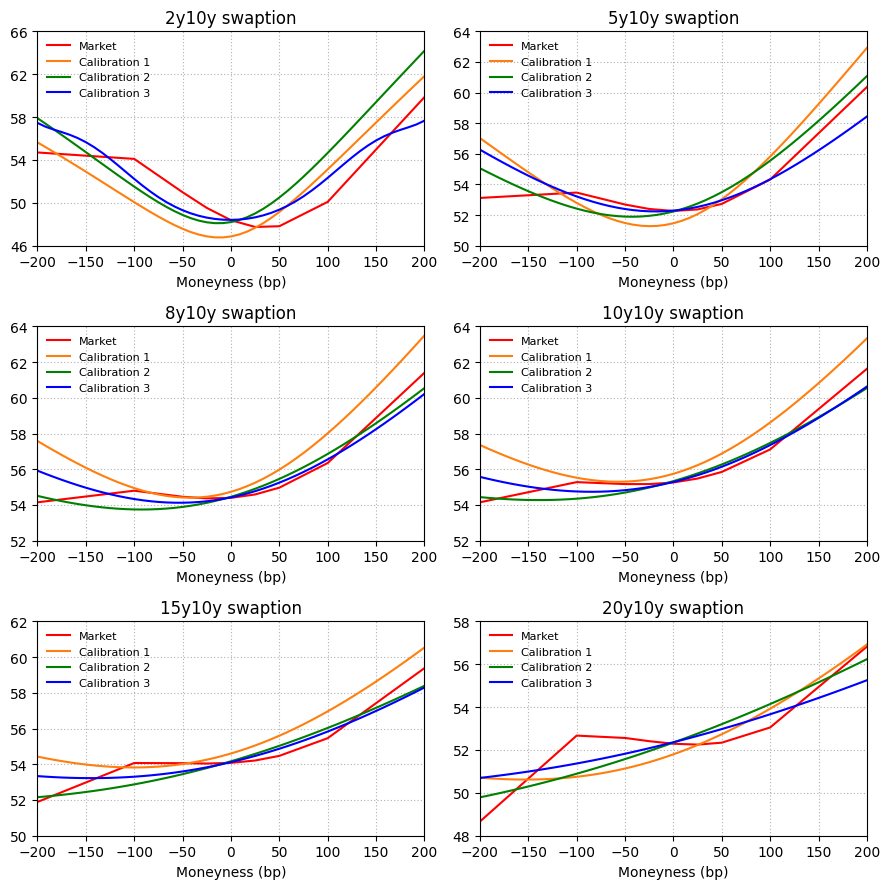

In [27]:
fig, ax = plt.subplots(3, 2, figsize=(9,9))

ax[0, 0].plot(iv_smiles[0].index, iv_smiles[0], label = 'Market', color = 'r')
ax[0, 0].plot(IV_1[0].index, IV_1[0], label = 'Calibration 1', color = '#ff7f0e')
ax[0, 0].plot(IV_2[0].index, IV_2[0], label = 'Calibration 2', color = 'g')
ax[0, 0].plot(IV_3[0].index, IV_3[0], label = 'Calibration 3', color = 'b')
ax[0, 0].set_title('2y10y swaption')
ax[0, 0].set_ylim(46,64)
ax[0, 0].set_yticks(np.arange(46,70,4))
ax[0, 0].set_xlim(min(IV_index), max(IV_index))
ax[0, 0].set_xlabel('Moneyness (bp)')
ax[0, 0].grid(ls = (0,(1,2)))
ax[0, 0].legend(frameon=False, fontsize=8)

ax[0, 1].plot(iv_smiles[1].index, iv_smiles[1], label = 'Market', color = 'r')
ax[0, 1].plot(IV_1[1].index, IV_1[1], label = 'Calibration 1', color = '#ff7f0e')
ax[0, 1].plot(IV_2[1].index, IV_2[1], label = 'Calibration 2', color = 'g')
ax[0, 1].plot(IV_3[1].index, IV_3[1], label = 'Calibration 3', color = 'b')
ax[0, 1].set_title('5y10y swaption')
ax[0, 1].set_ylim(50,64)
ax[0, 1].set_xlim(min(IV_index), max(IV_index))
ax[0, 1].set_xlabel('Moneyness (bp)')
ax[0, 1].grid(ls = (0,(1,2)))
ax[0, 1].legend(frameon=False, fontsize=8)

ax[1, 0].plot(iv_smiles[2].index, iv_smiles[2], label = 'Market', color = 'r')
ax[1, 0].plot(IV_1[2].index, IV_1[2], label = 'Calibration 1', color = '#ff7f0e')
ax[1, 0].plot(IV_2[2].index, IV_2[2], label = 'Calibration 2', color = 'g')
ax[1, 0].plot(IV_3[2].index, IV_3[2], label = 'Calibration 3', color = 'b')
ax[1, 0].set_title('8y10y swaption')
ax[1, 0].set_ylim(52,64)
ax[1, 0].set_xlim(min(IV_index), max(IV_index))
ax[1, 0].set_xlabel('Moneyness (bp)')
ax[1, 0].grid(ls = (0,(1,2)))
ax[1, 0].legend(frameon=False, fontsize=8)

ax[1, 1].plot(iv_smiles[3].index, iv_smiles[3], label = 'Market', color = 'r')
ax[1, 1].plot(IV_1[3].index, IV_1[3], label = 'Calibration 1', color = '#ff7f0e')
ax[1, 1].plot(IV_2[3].index, IV_2[3], label = 'Calibration 2', color = 'g')
ax[1, 1].plot(IV_3[3].index, IV_3[3], label = 'Calibration 3', color = 'b')
ax[1, 1].set_title('10y10y swaption')
ax[1, 1].set_ylim(52,64)
ax[1, 1].set_xlim(min(IV_index), max(IV_index))
ax[1, 1].set_xlabel('Moneyness (bp)')
ax[1, 1].grid(ls = (0,(1,2)))
ax[1, 1].legend(frameon=False, fontsize=8)

ax[2, 0].plot(iv_smiles[4].index, iv_smiles[4], label = 'Market', color = 'r')
ax[2, 0].plot(IV_1[4].index, IV_1[4], label = 'Calibration 1', color = '#ff7f0e')
ax[2, 0].plot(IV_2[4].index, IV_2[4], label = 'Calibration 2', color = 'g')
ax[2, 0].plot(IV_3[4].index, IV_3[4], label = 'Calibration 3', color = 'b')
ax[2, 0].set_title('15y10y swaption')
ax[2, 0].set_ylim(50,62)
ax[2, 0].set_xlim(min(IV_index), max(IV_index))
ax[2, 0].set_xlabel('Moneyness (bp)')
ax[2, 0].grid(ls = (0,(1,2)))
ax[2, 0].legend(frameon=False, fontsize=8)

ax[2, 1].plot(iv_smiles[5].index, iv_smiles[5], label = 'Market', color = 'r')
ax[2, 1].plot(IV_1[5].index, IV_1[5], label = 'Calibration 1', color = '#ff7f0e')
ax[2, 1].plot(IV_2[5].index, IV_2[5], label = 'Calibration 2', color = 'g')
ax[2, 1].plot(IV_3[5].index, IV_3[5], label = 'Calibration 3', color = 'b')
ax[2, 1].set_title('20y10y swaption')
ax[2, 1].set_ylim(48,58)
ax[2, 1].set_xlim(min(IV_index), max(IV_index))
ax[2, 1].set_xlabel('Moneyness (bp)')
ax[2, 1].grid(ls = (0,(1,2)))
ax[2, 1].legend(frameon=False, fontsize=8)

fig.tight_layout()
plt.show()

## Errors across all option expiries
##### Model

In [28]:
expiries = pd.Series(data = np.array([1/12, 3/12, 6/12, 9/12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30]), 
                     index = ["1Mo","3Mo","6Mo","9Mo","1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"])

points = ["1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"]

IV_3_errors = []

for i in range(len(points)):

    lambd = lambd_calibrated[points[i]]
    b = b_calibrated[points[i]]
    eta = eta_calibrated[points[i]]

    S = swaprate_strips[4][points[i]]

    strikes = np.array([S-200/10000, S-100/10000, S-50/10000, S-25/10000,
                        S-0/10000,
                        S+25/10000, S+50/10000, S+100/10000, S+200/10000])

    IV_index = np.round(np.linspace(-200, 200, len(strikes)),2)

    IV_i = pd.Series(np.zeros(len(strikes)),
                     index = IV_index)
  
    T = expiries[points[i]]

    for n in range(len(strikes)):

        K = strikes[n]
        def Root_Solving(x):
            return bachelier(S, K, x, date, T, tenor, tau_floating, t = 0) - payer_price_SV(S, K, S, theta, eta, lambd, b, z_0, date, T, tenor)
        res = fsolve(Root_Solving, 0.01)

        IV_i.iloc[n] = res * 10000   # convert to bp

    IV_3_errors.append(IV_i)

##### Market

In [29]:
expiries = ["1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"]
strike_index = np.array([-200, -100, -50, -25, 0, 25, 50, 100, 200])

iv_smiles = []

for i in range(len(expiries)):
    expiry = expiries[i]
    smile_i = pd.Series([df_swaption_iv[8].loc[expiry,"10Yr"], df_swaption_iv[7].loc[expiry,"10Yr"], df_swaption_iv[6].loc[expiry,"10Yr"], df_swaption_iv[5].loc[expiry,"10Yr"],                   
                         df_swaption_iv[4].loc[expiry,"10Yr"], # ATM
                         df_swaption_iv[3].loc[expiry,"10Yr"], df_swaption_iv[2].loc[expiry,"10Yr"], df_swaption_iv[1].loc[expiry,"10Yr"], df_swaption_iv[0].loc[expiry, "10Yr"]],
                         index = strike_index)
    iv_smiles.append(smile_i)

In [30]:
rmse = []

for i in range(len(points)):

    rmse_i = np.sqrt(mean_squared_error(iv_smiles[i], IV_3_errors[i]))
    rmse.append(rmse_i)

avg_rmse = np.average(rmse)
display(pd.DataFrame(data= rmse, index = expiries, columns = ['RMSE, Calibration 3']))
print("Average root mean squared error =", avg_rmse)

,"RMSE, Calibration 3"
1Yr,3.341571
2Yr,1.756448
3Yr,1.515922
4Yr,1.494888
5Yr,1.242985
6Yr,1.012685
7Yr,1.003250
8Yr,0.748681
9Yr,0.682517
10Yr,0.633253


Average root mean squared error = 1.2900684346873403
